In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np

### Maths Servers:

In [17]:
import sys
sys.path.append('/home/links/ct715/eddy_feedback/')
import functions.eddy_feedback as ef 
import functions.data_wrangling as data 

# import dataset for maths servers
ds = xr.open_mfdataset('/home/links/ct715/data_storage/reanalysis/srip_datasets/JRA55_srip_ubar_div1.nc',
                            parallel=True, chunks={'time': 31})

ds = data.seasonal_mean(ds, season='jas')
ds = data.check_dimensions(ds)
ds 

<xarray.Dataset>
Dimensions:  (time: 59, level: 22, lat: 73)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 600.0 ... 5.0 3.0 2.0 1.0
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * time     (time) int64 1958 1959 1960 1961 1962 ... 2012 2013 2014 2015 2016
Data variables:
    ubar     (time, level, lat) float32 dask.array<chunksize=(5, 22, 73), meta=np.ndarray>
    div1_pr  (time, level, lat) float32 dask.array<chunksize=(5, 22, 73), meta=np.ndarray>
    div1_qg  (time, level, lat) float32 dask.array<chunksize=(5, 22, 73), meta=np.ndarray>

### JASMIN Servers:

In [18]:
# import sys
# sys.path.append('/home/users/cturrell/documents/eddy_feedback/')
# import functions.eddy_feedback as ef
# import functions.data_wrangling as data 

# # import dataset for JASMIN servers
# ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/srip_datasets/jra55*.nc',
#                             parallel=True, chunks={'time': 31})

# ds = data.seasonal_mean(ds, season='jas')
# ds = data.check_dimensions(ds, ignore_dim='lon')
# ds 

# Zonal-mean zonal wind (DJF)

In [19]:
# define zonal mean zonal wind
u = ds.ubar

# slice data at 500hPA and set SH boundaries
u = u.sel( level = 500. )
u = u.where( ds.lat >= -75., drop=True )
u = u.where( ds.lat <= -25., drop=True )

# flip axes so time on x-axis
u = u.transpose()

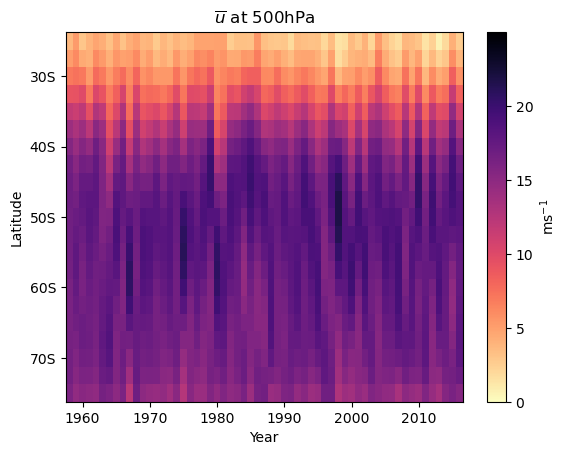

In [20]:
fig, ax = plt.subplots()
u.plot(ax=ax, cmap='magma_r', vmin=0, vmax=25,
       cbar_kwargs={'label': 'ms$^{-1}$', 'ticks':[0, 5, 10, 15, 20]})
ax.set_yticks(np.arange(-70,-20,10))
ax.set_yticklabels(['30S', '40S', '50S', '60S', '70S'])
ax.invert_yaxis()
ax.set_title('$\\overline{u}$ at 500hPa')
ax.set_ylabel('Latitude')
ax.set_xlabel('Year')
plt.show()

# DJF Northward EP Flux Divergence

In [21]:
# separate into interannual means
# div1 = ds.div1_pr / 86400 
div1 = ds.div1_pr

# slice data at 500hPA and set EFP boundaries
div1 = div1.sel( level = 500. )
div1 = div1.where( ds.lat >= -75., drop=True )
div1 = div1.where( ds.lat <= -25., drop=True )

# flip axes so time on x-axis
div1 = div1.transpose()

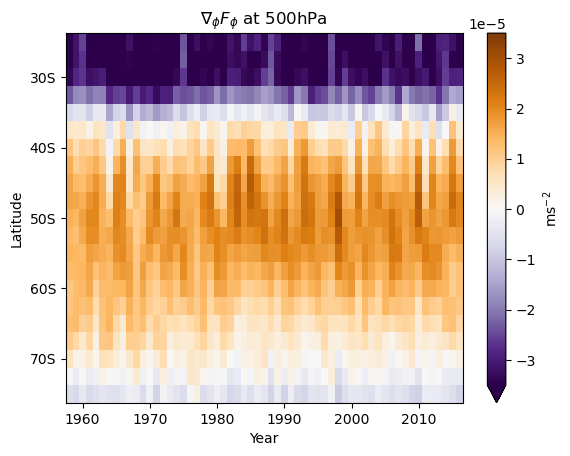

In [22]:
fig, ax = plt.subplots()
div1.plot(ax=ax, cmap='PuOr_r', vmin=-3.5e-5, vmax=3.5e-5,
       cbar_kwargs={'label': 'ms$^{-2}$'})
ax.set_yticks(np.arange(-70,-20,10))
ax.set_yticklabels(['30S', '40S', '50S', '60S', '70S'])
ax.invert_yaxis()
ax.set_title('$\\nabla_\\phi F_\\phi$ at 500hPa')
ax.set_ylabel('Latitude')
ax.set_xlabel('Year')
plt.show()

# Plot both Figures

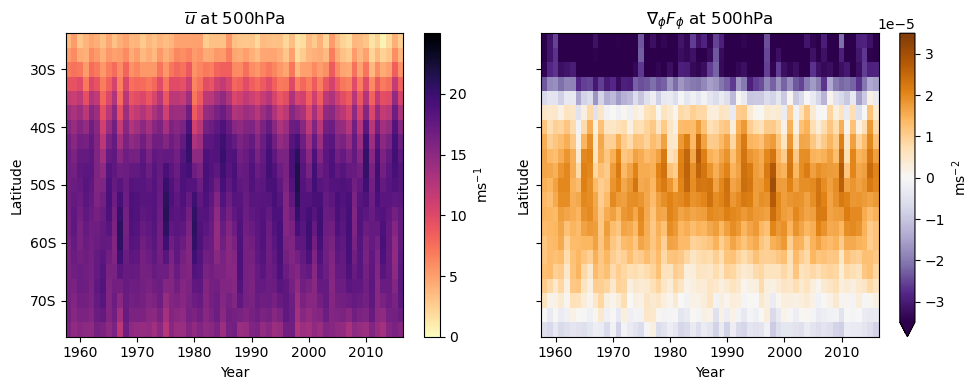

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,4))

# plot ubar 
u.plot(ax=ax1, cmap='magma_r', vmin=0, vmax=25,
       cbar_kwargs={'label': 'ms$^{-1}$', 'ticks':[0, 5, 10, 15, 20]})
ax1.set_yticks(np.arange(-70,-20,10))
ax1.set_yticklabels(['30S', '40S', '50S', '60S', '70S'])
ax1.invert_yaxis()
ax1.set_title('$\\overline{u}$ at 500hPa')
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Year')


# plot div1 
div1.plot(ax=ax2, cmap='PuOr_r', vmin=-3.5e-5, vmax=3.5e-5,
       cbar_kwargs={'label': 'ms$^{-2}$'})
ax2.set_yticks(np.arange(-70,-20,10))
ax2.set_yticklabels(['30S', '40S', '50S', '60S', '70S'])
ax2.invert_yaxis()
ax2.set_title('$\\nabla_\\phi F_\\phi$ at 500hPa')
ax2.set_ylabel('Latitude')
ax2.set_xlabel('Year')

plt.tight_layout()
plt.show()

# Covariance

In [24]:
uanom = (u- u.mean('time'))
div1anom = (div1- div1.mean('time') )

prod = uanom*div1anom

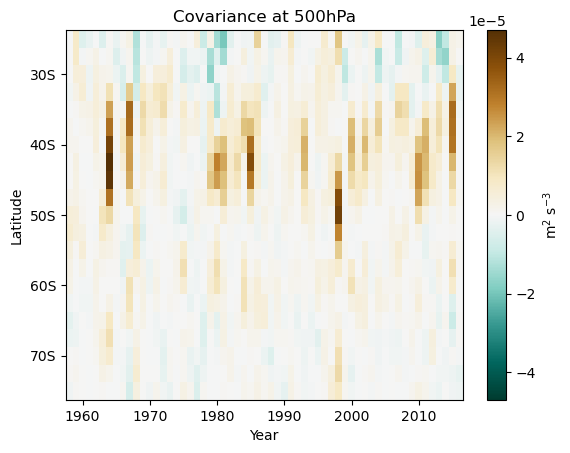

In [25]:
fig, ax = plt.subplots()
prod.plot(ax=ax, cmap='BrBG_r', 
          cbar_kwargs={'label': 'm$^2$ s$^{-3}$'})#, 'ticks':[-5e-5,0,5e-5]})
ax.set_title('Covariance at 500hPa')
ax.set_yticks(np.arange(-70,-20,10))
ax.set_yticklabels(['30S', '40S', '50S', '60S', '70S'])
ax.invert_yaxis()
ax.set_ylabel('Latitude')
ax.set_xlabel('Year')
plt.show()

# Correlation

In [26]:
ustd = u.std()
div1std = div1.std()

corr = prod / (ustd * div1std)

In [27]:
# somehow greater than 1????
corr = corr.where( corr < 1)
corr = corr.fillna(1)

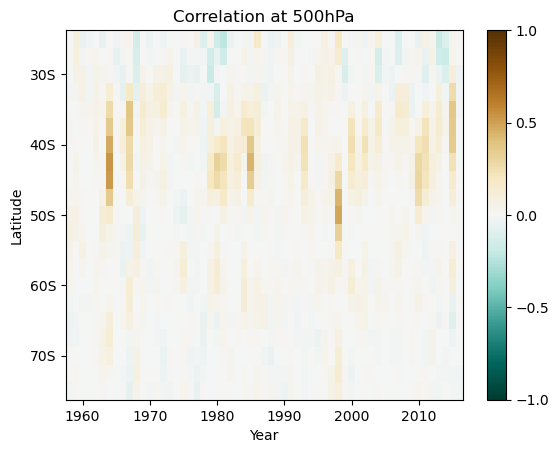

In [28]:
fig, ax = plt.subplots()
corr.plot(ax=ax, cmap='BrBG_r', vmin=-1., vmax=1,
          cbar_kwargs={'ticks':[-1,-0.5,0,0.5,1]}) 
ax.set_title('Correlation at 500hPa')
ax.set_yticks(np.arange(-70,-20,10))
ax.set_yticklabels(['30S', '40S', '50S', '60S', '70S'])
ax.invert_yaxis()
ax.set_ylabel('Latitude')
ax.set_xlabel('Year')
plt.show()

# Reset data

### JASMIN

In [29]:
# # import dataset for JASMIN servers
# ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/srip_datasets/jra55*.nc',
#                             parallel=True, chunks={'time': 31})

# ds = data.seasonal_mean(ds, season='jas')
# ds = data.check_dimensions(ds, ignore_dim='lon')
# ds 

### Maths Servers

In [31]:
# import dataset for maths servers
ds = xr.open_mfdataset('/home/links/ct715/data_storage/reanalysis/srip_datasets/JRA55_srip_ubar_div1.nc',
                            parallel=True, chunks={'time': 31})

ds = data.seasonal_mean(ds, season='jas')
ds = data.check_dimensions(ds)
ds 

<xarray.Dataset>
Dimensions:  (time: 59, level: 22, lat: 73)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 600.0 ... 5.0 3.0 2.0 1.0
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * time     (time) int64 1958 1959 1960 1961 1962 ... 2012 2013 2014 2015 2016
Data variables:
    ubar     (time, level, lat) float32 dask.array<chunksize=(5, 22, 73), meta=np.ndarray>
    div1_pr  (time, level, lat) float32 dask.array<chunksize=(5, 22, 73), meta=np.ndarray>
    div1_qg  (time, level, lat) float32 dask.array<chunksize=(5, 22, 73), meta=np.ndarray>

In [32]:
ds = ds.sel(level=500.)
ds = ds.sel(lat=slice(-75,-25))

corr2 = xr.corr(ds.ubar, ds.div1_pr, dim='time')

corr2 

<xarray.DataArray (lat: 21)>
dask.array<truediv, shape=(21,), dtype=float64, chunksize=(21,), chunktype=numpy.ndarray>
Coordinates:
    level    float32 500.0
  * lat      (lat) float32 -75.0 -72.5 -70.0 -67.5 ... -32.5 -30.0 -27.5 -25.0

# Plot all figures

(11.023622047244094, 7.086614173228346)


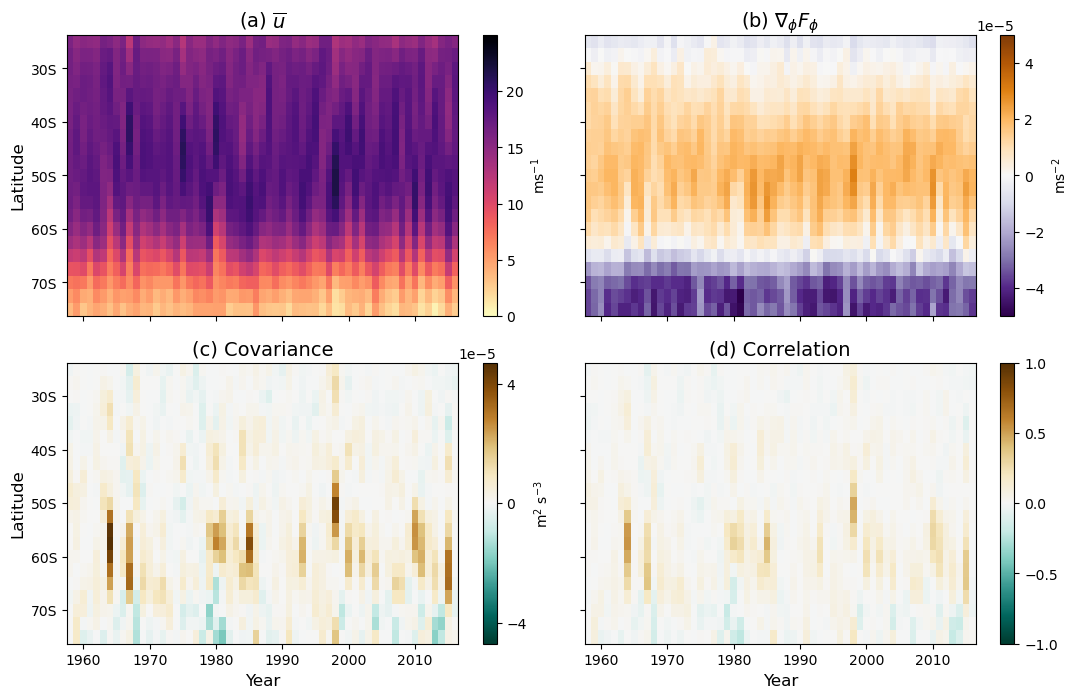

In [33]:
inches = 1/25.4 

width = 280 #(180/4)*3
height = 180 #(325/4)*3

figsize = (width*inches, height*inches)
print(figsize)

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=figsize)

# plot ubar
u.plot(ax=axs[0,0], cmap='magma_r', vmin=0, vmax=25,
       cbar_kwargs={'label': 'ms$^{-1}$', 'ticks':[0, 5, 10, 15, 20]})
axs[0,0].set_yticks(np.arange(-70,-20, 10))
axs[0,0].set_yticklabels(['70S', '60S', '50S', '40S', '30S'])
axs[0,0].set_title('(a) $\\overline{u}$', fontsize=14)
axs[0,0].set_ylabel('Latitude', fontsize=12)
axs[0,0].set_xlabel('')


# plot div1
div1.plot(ax=axs[0,1], cmap='PuOr_r',
       cbar_kwargs={'label': 'ms$^{-2}$'})
axs[0,1].set_title('(b) $\\nabla_\\phi F_\\phi$', fontsize=14)
axs[0,1].set_ylabel('')
axs[0,1].set_xlabel('')

# plot covariance
prod.plot(ax=axs[1,0], cmap='BrBG_r', 
          cbar_kwargs={'label': 'm$^2$ s$^{-3}$', 'ticks':[-4e-5, 0, 4e-5]})
axs[1,0].set_title('(c) Covariance', fontsize=14)
axs[1,0].set_ylabel('Latitude', fontsize=12)
axs[1,0].set_xlabel('Year', fontsize=12)

# plot correlation
corr.plot(ax=axs[1,1], cmap='BrBG_r', vmin=-1., vmax=1.,
          cbar_kwargs={'ticks':[-1,-0.5,0,0.5,1]})
axs[1,1].set_title('(d) Correlation', fontsize=14)
axs[1,1].set_ylabel('')
axs[1,1].set_xlabel('Year', fontsize=12)

# fig.suptitle('Figure 3: Eddy Feedback Parameter at 500hPa', fontsize=16)

plt.tight_layout()
plt.show()

### Northern Hemisphere Covariance

In [34]:
# uanom = (u- u.mean('time'))
# div1anom = (div1- div1.mean('time') )

# prod = uanom*div1anom

# Match colour bars

(11.023622047244094, 7.086614173228346)


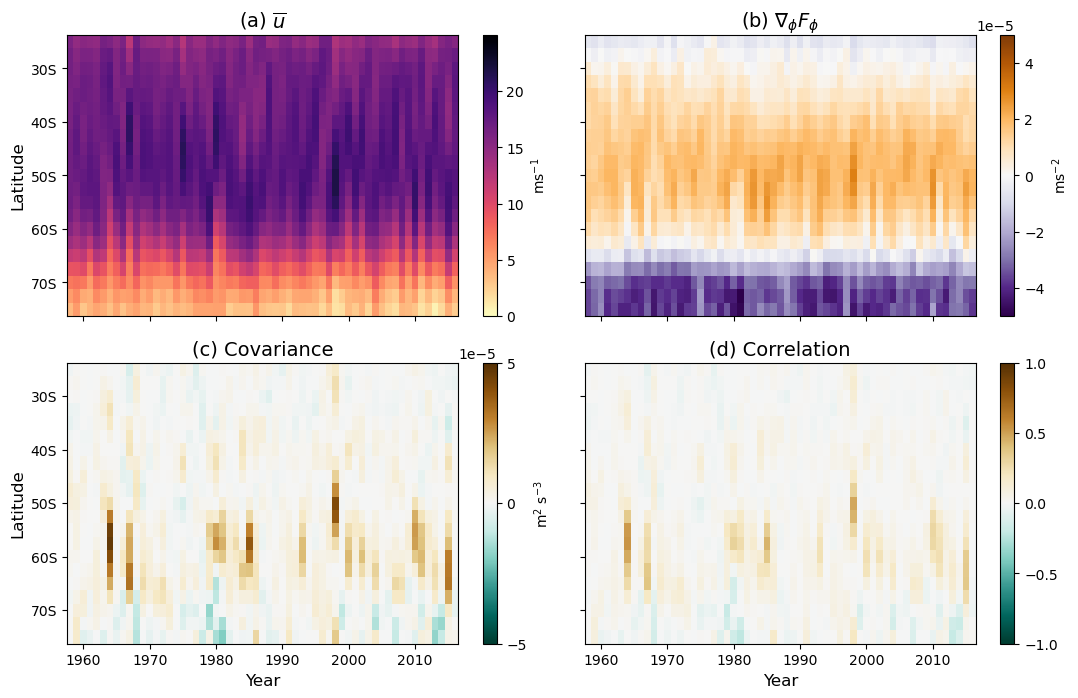

In [35]:
inches = 1/25.4 

width = 280 #(180/4)*3
height = 180 #(325/4)*3

figsize = (width*inches, height*inches)
print(figsize)

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=figsize)

# plot ubar
u.plot(ax=axs[0,0], cmap='magma_r', vmin=0, vmax=25,
       cbar_kwargs={'label': 'ms$^{-1}$', 'ticks':[0, 5, 10, 15, 20]})
axs[0,0].set_yticks(np.arange(-70,-20, 10))
axs[0,0].set_yticklabels(['70S', '60S', '50S', '40S', '30S'])
axs[0,0].set_title('(a) $\\overline{u}$', fontsize=14)
axs[0,0].set_ylabel('Latitude', fontsize=12)
axs[0,0].set_xlabel('')

# plot div1
div1.plot(ax=axs[0,1], cmap='PuOr_r',
       cbar_kwargs={'label': 'ms$^{-2}$'})
axs[0,1].set_title('(b) $\\nabla_\\phi F_\\phi$', fontsize=14)
axs[0,1].set_ylabel('')
axs[0,1].set_xlabel('')

# plot covariance
# Ensure that vmin and vmax are the same as in the first subplot
prod.plot(ax=axs[1,0], cmap='BrBG_r', vmin=-5e-5, vmax=5e-5, 
          cbar_kwargs={'label': 'm$^2$ s$^{-3}$', 'ticks':[-5e-5, 0, 5e-5]})
axs[1,0].set_title('(c) Covariance', fontsize=14)
axs[1,0].set_ylabel('Latitude', fontsize=12)
axs[1,0].set_xlabel('Year', fontsize=12)

# plot correlation
corr.plot(ax=axs[1,1], cmap='BrBG_r', vmin=-1., vmax=1.,
          cbar_kwargs={'ticks':[-1,-0.5,0,0.5,1]})
axs[1,1].set_title('(d) Correlation', fontsize=14)
axs[1,1].set_ylabel('')
axs[1,1].set_xlabel('Year', fontsize=12)

plt.tight_layout()
plt.show()
